# Kaggle Competition: Quora Question Pairs

Link to competition : 
https://www.kaggle.com/c/quora-question-pairs

Contents: 
0. Setup 
1. My First NLP Neural Network
2. Cleaning the text, and using this for my second NLP neural network
3. Adding leaky features

In [1]:
% matplotlib inline 

import re

import pandas as pd
import numpy as np 

from itertools import cycle
import string
import os
from collections import Counter
from tqdm import *

import cPickle as pickle

import bcolz

import seaborn as sns
import matplotlib.pyplot as plt

from keras.layers.embeddings import Embedding
from keras.layers import Input, merge, TimeDistributed
from keras.models import Model
from keras.layers.core import Flatten, Dropout, Dense
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Convolution1D, Conv1D

from keras.regularizers import l1, l2

from keras.layers.recurrent import GRU, LSTM

from keras import backend as K

from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

from keras.utils.np_utils import to_categorical
import gc

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)


## Importing the data

In [2]:
train = pd.read_csv('data/Quora/train.csv')

In [3]:
train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


## Preprocessing

So I want to take as inputs questions 1 and 2, and as outputs 1 if it is a duplicate, and 0 if it is not. 

The first thing I want to be able to do is take each question, and turn it into embeddings. First, I'm going to turn them into an array of words, using Keras' tokenizer. A challenge when I do this is that I need to set a max number of words. There are empty cells in question 2 (for some reason??). I'm just going to ignore them. 

In [4]:
num = 0 
for i in train.question2.isnull():
    if i == True:
        num += 1
print str(num) + " questions in question 2 are null"

2 questions in question 2 are null


In [5]:
num = 0 
for i in train.question1.isnull():
    if i == True:
        num += 1
print str(num) + " questions in question 1 are null"

0 questions in question 1 are null


In [6]:
len(train)

404290

In [7]:
train = train[train.question2.notnull()]
train = train[train.question1.notnull()]

In [8]:
len(train)

404288

In [9]:
MAX_Q1_LENGTH = np.amax(train.question1.apply(lambda x: len(x.split())))
MAX_Q2_LENGTH = np.amax(train.question2.apply(lambda y: len(y.split())))

Mean_q1_length = train.question1.apply(lambda x: len(x.split())).mean()
Mean_q2_length = train.question2.apply(lambda x: len(x.split())).mean()

print "The longest question length is " + str(np.amax(np.asarray([MAX_Q1_LENGTH, MAX_Q2_LENGTH]))) + " words"
print "The mean question lengths are " + str(Mean_q1_length) + " and " +  str(Mean_q2_length)

The longest question length is 237 words
The mean question lengths are 10.9422317754 and 11.1820410203


In [10]:
q1_lengths = np.asarray([train.question1.apply(lambda x: len(x.split()))])[0]
q2_lengths = np.asarray([train.question2.apply(lambda x: len(x.split()))])[0]

(0, 50)

/home/ubuntu/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


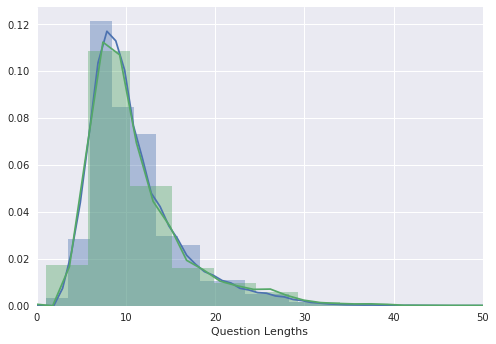

In [11]:
sns.distplot(q1_lengths)
sns.distplot(q2_lengths)
plt.xlabel('Question Lengths')
plt.xlim(0,50)

237 words takes a LONG time to train, and most questions are far shorter. 35 words is a reasonable limit, as very few questions are longer than this. 

In [12]:
MAX_LENGTH = 35

So I want to turn all of the words in all of my Quora questions into an array, with each word associated with an index. 

In [15]:
tokenizer = Tokenizer(nb_words = 20000)
tokenizer.fit_on_texts(train.question1 + train.question2)

In [16]:
q1sequence = tokenizer.texts_to_sequences(train.question1)
q2sequence = tokenizer.texts_to_sequences(train.question2)

In [17]:
word_index = tokenizer.word_index

In [18]:
word_index

{'icici': 4000,
 'daiict': 28264,
 'utnapishtim': 42163,
 'sonja': 55750,
 'devonians': 55751,
 'vani': 21311,
 'woods': 11688,
 'spiders': 5377,
 'hanging': 5495,
 'paiza': 55752,
 'woody': 19376,
 'localized': 13595,
 'regularize': 55753,
 'disobeying': 31248,
 "'guess'": 55754,
 'lottoland': 55755,
 'chatter': 37603,
 'googlenet': 55757,
 'refunding': 42164,
 'shadowdancer': 55758,
 'crossbar': 55805,
 'rickman': 31249,
 'justgiving': 55760,
 "propeller's": 55761,
 'naturopathic': 55762,
 "blg'": 55763,
 'pigment': 31250,
 'tourister': 20284,
 'replaces': 28265,
 'gazatted': 55764,
 'broward': 55765,
 'bringing': 3749,
 'throwaround': 55766,
 'kaushal': 42165,
 'grueling': 55767,
 'vibrational': 31251,
 'wooden': 11689,
 'wednesday': 10397,
 'vologda': 55768,
 'salination': 55769,
 'chameleons': 42166,
 'sericin': 55770,
 'crotch': 17159,
 'amplifications': 55771,
 'light\xe2\x80\xa6': 55772,
 '330ml': 42167,
 'girokonto': 55773,
 'thrace': 42168,
 "tom's": 50411,
 '1070s': 55774,
 

So we have now turned our words into indices based on how commonly they occur in the text (I **haven't** implemented word embeddings yet!). I now want all of my sequences to be the same length, since neural nets require uniformly sized inputs. 

In [19]:
q1_input = pad_sequences(q1sequence, maxlen = MAX_LENGTH)
q2_input = pad_sequences(q2sequence, maxlen = MAX_LENGTH)

In [26]:
labels = np.asarray(train.is_duplicate)
labels

array([0, 0, 0, ..., 0, 0, 0])

Awesome. So now, I can turn my arrays into my train and validation subsets. 

In [21]:
msk = np.random.rand(len(train)) < 0.8

q1_train = q1_input[msk]
q1_valid = q1_input[~msk]

q2_train = q2_input[msk]
q2_valid = q2_input[~msk]

labels_train = labels[msk]
labels_valid = labels[~msk]

Awesome! Now, I want to turn this array of word indices into an array of embeddings, as calculated in GloVe. 

In [13]:
embeddings_index = {}
f = open('data/glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [14]:
EMBEDDING_DIM = 300

Now that I have the embeddings, I want to turn these into weights, where each word index in my sample of questions can be turned into its appropriate 50-dimensional embedding. 

In [27]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [28]:
embedding_matrix[i]

array([ -1.88789994e-01,   2.50649989e-01,  -6.05459988e-01,
        -2.40860000e-01,   1.28209993e-01,   3.69299985e-02,
        -4.22960013e-01,  -8.34050030e-02,   1.41049996e-01,
         1.06870003e-01,  -5.46899974e-01,   9.27890018e-02,
         2.53780000e-02,   1.61369994e-01,  -2.55959988e-01,
        -2.48830006e-01,   7.82350004e-01,   9.27449986e-02,
         8.40749964e-02,   1.28600001e-01,  -7.39170015e-02,
         1.95130005e-01,   2.72949994e-01,  -1.01570003e-01,
        -1.35900006e-01,  -5.36090016e-01,   3.47059988e-03,
         1.27379999e-01,   2.80669987e-01,   6.26619995e-01,
         1.23100001e-02,   9.57920030e-02,   1.63680002e-01,
         7.46719986e-02,   7.01099992e-01,   7.94999972e-02,
        -4.66800004e-01,   2.39789993e-01,   2.52359986e-01,
         5.09989977e-01,  -2.84509987e-01,   7.06160009e-01,
        -3.82990018e-02,  -1.12170003e-01,  -1.14080003e-02,
         3.88399988e-01,   1.78330004e-01,  -3.12680006e-01,
        -1.27920002e-01,

Wow that was INSANELY easier than I had made it be. 

Now I can train a neural network!

In [29]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_LENGTH,
                            trainable=False)

## My first NLP Neural Network

In [30]:
q1_input = Input(shape=(MAX_LENGTH,), dtype = 'int32')
q1_embedded = embedding_layer(q1_input)
q1 = BatchNormalization(axis =1)(q1_embedded)

q1 = LSTM(225, dropout_U = 0.2, dropout_W = 0.2, consume_less='gpu' )(q1)
q1 = Dropout(0.5)(q1)

#########################

q2_input = Input(shape=(MAX_LENGTH,), dtype = 'int32')
q2_embedded = embedding_layer(q2_input)
q2 = BatchNormalization(axis = 1)(q2_embedded)

q2 = LSTM(225, dropout_U = 0.2, dropout_W = 0.2,  consume_less='gpu')(q2)
q2 = Dropout(0.5)(q2)

#########################

x = merge([q1, q2], mode = 'concat')
x = BatchNormalization()(x)

x = Dense(125)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)

preds = Dense(1, activation = 'sigmoid')(x)

In [31]:
nlp_nn = Model([q1_input, q2_input], preds)
nlp_nn.compile(Adam(0.001), loss = 'binary_crossentropy')

In [32]:
nlp_hist = nlp_nn.fit([q1_train, q2_train], labels_train, batch_size = 2048, nb_epoch = 5, 
                     validation_data=([q1_valid, q2_valid],labels_valid))

Train on 322894 samples, validate on 81394 samples
Epoch 1/5
322894/322894 [==============================] - 130s - loss: 0.6974 - val_loss: 1.8058
Epoch 2/5
322894/322894 [==============================] - 131s - loss: 0.6780 - val_loss: 2.0172
Epoch 3/5
322894/322894 [==============================] - 131s - loss: 0.6685 - val_loss: 1.7993
Epoch 4/5
322894/322894 [==============================] - 131s - loss: 0.6639 - val_loss: 1.5349
Epoch 5/5
322894/322894 [==============================] - 131s - loss: 0.6615 - val_loss: 1.4161


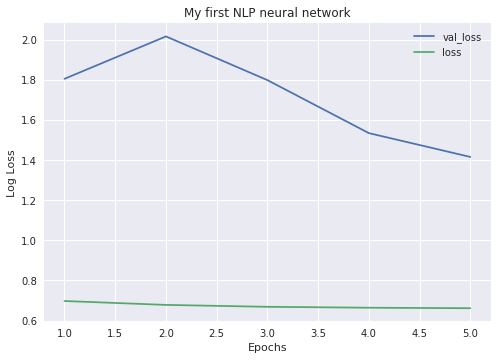

In [44]:
plt.plot(range(1,6), nlp_hist.history['val_loss'], label = 'val_loss')
plt.plot(range(1,6), nlp_hist.history['loss'], label = 'loss')
plt.title("My first NLP neural network")
plt.xlabel("Epochs")
plt.ylabel("Log Loss")
plt.legend()
plt.show()

Okay, not a great start. Considering I just picked the words from the dataset, this makes sense; there's plenty more to do.

The first thing which could be affecting the strength of my neural network is the zeroed values in the embedding matrix (remember if a word is not in the GloVe dictionary, I just set it to zeroes). Lets take a look at some of the words which are zeroed out. 

In [34]:
not_found = []
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is None:
        # words not found in embedding index will be all-zeros.
        not_found.append(word)

In [37]:
print "Out of " + str(len(word_index.items())) + " words, " + str(len(not_found)) + " don't have Glove equivalents."

Out of 96500 words, 36169 don't have Glove equivalents.


So there are 36,000 words which aren't assigned values, and are all zeroed. This may be contributing to the low performance of my neural network. Let's take a look at some of the words which aren't being embedded. 

Okay, so part of the problem is the text itself, which is full of eccentricities. Luckily, someone on Kaggle (a 'Kaggler?') has already written a method to clean up this text, so lets jump on that train. 

## Cleaning up the text 
https://www.kaggle.com/currie32/the-importance-of-cleaning-text

In [15]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
from string import punctuation

In [16]:
stop_words = ['the','a','an','and','but','if','or','because','as','what','which','this','that','these','those','then',
              'just','so','than','such','both','through','about','for','is','of','while','during','to','What','Which',
              'Is','If','While','This']

In [17]:
def text_to_wordlist(text, remove_stop_words=True, stem_words=False):
    # Clean the text, with the option to remove stop_words and to stem words.

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9]", " ", text)
    text = re.sub(r"what's", "", text)
    text = re.sub(r"What's", "", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"I'm", "I am", text)
    text = re.sub(r" m ", " am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"60k", " 60000 ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e-mail", "email", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = re.sub(r"quikly", "quickly", text)
    text = re.sub(r" usa ", " America ", text)
    text = re.sub(r" USA ", " America ", text)
    text = re.sub(r" u s ", " America ", text)
    text = re.sub(r" uk ", " England ", text)
    text = re.sub(r" UK ", " England ", text)
    text = re.sub(r"india", "India", text)
    text = re.sub(r"switzerland", "Switzerland", text)
    text = re.sub(r"china", "China", text)
    text = re.sub(r"chinese", "Chinese", text) 
    text = re.sub(r"imrovement", "improvement", text)
    text = re.sub(r"intially", "initially", text)
    text = re.sub(r"quora", "Quora", text)
    text = re.sub(r" dms ", "direct messages ", text)  
    text = re.sub(r"demonitization", "demonetization", text) 
    text = re.sub(r"actived", "active", text)
    text = re.sub(r"kms", " kilometers ", text)
    text = re.sub(r"KMs", " kilometers ", text)
    text = re.sub(r" cs ", " computer science ", text) 
    text = re.sub(r" upvotes ", " up votes ", text)
    text = re.sub(r" iPhone ", " phone ", text)
    text = re.sub(r"\0rs ", " rs ", text) 
    text = re.sub(r"calender", "calendar", text)
    text = re.sub(r"ios", "operating system", text)
    text = re.sub(r"gps", "GPS", text)
    text = re.sub(r"gst", "GST", text)
    text = re.sub(r"programing", "programming", text)
    text = re.sub(r"bestfriend", "best friend", text)
    text = re.sub(r"dna", "DNA", text)
    text = re.sub(r"III", "3", text) 
    text = re.sub(r"the US", "America", text)
    text = re.sub(r"Astrology", "astrology", text)
    text = re.sub(r"Method", "method", text)
    text = re.sub(r"Find", "find", text) 
    text = re.sub(r"banglore", "Banglore", text)
    text = re.sub(r" J K ", " JK ", text)
    
    # Remove punctuation from text
    text = ''.join([c for c in text if c not in punctuation])
    
    # Optionally, remove stop words
    if remove_stop_words:
        text = text.split()
        text = [w for w in text if not w in stop_words]
        text = " ".join(text)
    
    # Optionally, shorten words to their stems
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
    
    # Return a list of words
    return(text)

In [18]:
def process_questions(question_list, questions, question_list_name, dataframe):
    '''transform questions and display progress'''
    for question in tqdm(questions):
        question_list.append(text_to_wordlist(question))

In [19]:
train_question1 = []
process_questions(train_question1, train.question1, 'train_question1', train)

100%|██████████| 404288/404288 [00:40<00:00, 10065.01it/s]


In [20]:
train_question2 = []
process_questions(train_question2, train.question2, 'train_question2', train)

100%|██████████| 404288/404288 [00:39<00:00, 10112.31it/s]


Great. Let's try preparing the data for my neural network again. 

In [21]:
cleaned_tokenizer = Tokenizer(nb_words = 20000)
cleaned_tokenizer.fit_on_texts(train_question1 + train_question2)

In [22]:
clean_q1sequence = cleaned_tokenizer.texts_to_sequences(train_question1)
clean_q2sequence = cleaned_tokenizer.texts_to_sequences(train_question2)

In [23]:
clean_word_index = cleaned_tokenizer.word_index

In [25]:
clean_not_found = []
for word, i in clean_word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is None:
        # words not found in embedding index will be all-zeros.
        clean_not_found.append(word)

In [26]:
print "Out of " + str(len(clean_word_index.items())) + " words, " + str(len(clean_not_found)) + " don't have Glove equivalents."

Out of 85424 words, 24657 don't have Glove equivalents.


So by reducing the number of unique words, and rewriting some of the words, we've reduced the % of words not being recognized from 37% to 29%. Success!

In [24]:
clean_q1_input = pad_sequences(clean_q1sequence, maxlen = MAX_LENGTH)
clean_q2_input = pad_sequences(clean_q2sequence, maxlen = MAX_LENGTH)

In [27]:
msk = np.random.rand(len(train)) < 0.8

clean_q1_train = clean_q1_input[msk]
clean_q1_valid = clean_q1_input[~msk]

clean_q2_train = clean_q2_input[msk]
clean_q2_valid = clean_q2_input[~msk]

clean_labels_train = labels[msk]
clean_labels_valid = labels[~msk]

## My 2nd NLP Neural Network
Spoiler: It's identical to my first one!

In [28]:
clean_embedding_matrix = np.zeros((len(clean_word_index) + 1, EMBEDDING_DIM))
for word, i in clean_word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        clean_embedding_matrix[i] = embedding_vector

In [29]:
clean_embedding_layer = Embedding(len(clean_word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[clean_embedding_matrix],
                            input_length=MAX_LENGTH,
                            trainable=False)

In [54]:
clean_q1_input = Input(shape=(MAX_LENGTH,), dtype = 'int32')
q1_embedded = clean_embedding_layer(clean_q1_input)
q1 = BatchNormalization(axis =1)(q1_embedded)

q1 = LSTM(225, dropout_U = 0.2, dropout_W = 0.2, consume_less='gpu' )(q1)
q1 = Dropout(0.5)(q1)

#########################

clean_q2_input = Input(shape=(MAX_LENGTH,), dtype = 'int32')
q2_embedded = clean_embedding_layer(clean_q2_input)
q2 = BatchNormalization(axis = 1)(q2_embedded)

q2 = LSTM(225, dropout_U = 0.2, dropout_W = 0.2,  consume_less='gpu')(q2)
q2 = Dropout(0.5)(q2)

#########################

x = merge([q1, q2], mode = 'concat')
x = BatchNormalization()(x)

x = Dense(125)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)

clean_preds = Dense(1, activation = 'sigmoid')(x)

In [55]:
clean_nlp_nn = Model([clean_q1_input, clean_q2_input], clean_preds)
clean_nlp_nn.compile(Adam(0.001), loss = 'binary_crossentropy')

In [57]:
clean_nlp_hist = clean_nlp_nn.fit([clean_q1_train, clean_q2_train], clean_labels_train, batch_size = 2048, nb_epoch = 5, 
                     validation_data=([clean_q1_valid, clean_q2_valid],clean_labels_valid))

Train on 323690 samples, validate on 80598 samples
Epoch 1/5
323690/323690 [==============================] - 131s - loss: 0.7066 - val_loss: 1.7292
Epoch 2/5
323690/323690 [==============================] - 131s - loss: 0.6801 - val_loss: 1.6089
Epoch 3/5
323690/323690 [==============================] - 131s - loss: 0.6759 - val_loss: 1.4448
Epoch 4/5
323690/323690 [==============================] - 132s - loss: 0.6717 - val_loss: 1.1553
Epoch 5/5
323690/323690 [==============================] - 132s - loss: 0.6688 - val_loss: 1.0955


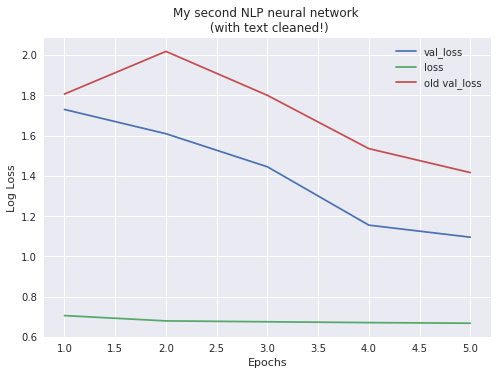

In [61]:
plt.plot(range(1,6), clean_nlp_hist.history['val_loss'], label = 'val_loss')
plt.plot(range(1,6), clean_nlp_hist.history['loss'], label = 'loss')
plt.plot(range(1,6), nlp_hist.history['val_loss'], label = 'old val_loss')
plt.title("My second NLP neural network \n (with text cleaned!)")
plt.xlabel("Epochs")
plt.ylabel("Log Loss")
plt.legend()
plt.show()

As Jeremy from fast.ai says, 'overfitting is only bad if its affecting your validation results'; here, the validation loss seem to be dropping quite quickly! So we're doing better, but there's still a lot of improving which can happen. 

It's worth noting that although these scores are pretty awful, I've only trained my network for 5 epochs; many of the better scores on Kaggle were trained for ~200 epochs, and I'm confident that training this network more would reduce the loss significantly, as the validation loss hasn't converged at all. 

## Adding leaky features

So far, my neural network has only been built on the input words. However, the questions contain far more information, which I'm not taking advantage of at all. In this case, there are two additional features which are very predictive of whether or not a question is a duplicate: 

1 [Frequency](https://www.kaggle.com/jturkewitz/magic-features-0-03-gain), which is the frequency of a question in the dataset

2 [Interesection](https://www.kaggle.com/tour1st/magic-feature-v2-0-045-gain), which defines how many questions have indices common to others. 

To incorporate these into my network, I'm going to make an additional input to my neural network, 'leaky features'. 

First, I want to isolate the questions:

In [30]:
ques = train[['question1', 'question2']]
print(ques.shape)

(404288, 2)


Then, I want to add them all to a dictionary: 

In [31]:
from collections import defaultdict
q_dict = defaultdict(set)
for i in tqdm(range(ques.shape[0])):
        q_dict[ques.iloc[i].question1].add(ques.iloc[i].question2)
        q_dict[ques.iloc[i].question2].add(ques.iloc[i].question1)

100%|██████████| 404288/404288 [03:12<00:00, 2103.26it/s]


Excellent. I can now use this dictionary to define these leaky features. 

In [32]:
def q1_freq(row):
    return(len(q_dict[row['question1']]))
    
def q2_freq(row):
    return(len(q_dict[row['question2']]))
    
def q1_q2_intersect(row):
    return(len(set(q_dict[row['question1']]).intersection(set(q_dict[row['question2']]))))

train['q1_q2_intersect'] = train.apply(q1_q2_intersect, axis=1, raw=True)
train['q1_freq'] = train.apply(q1_freq, axis=1, raw=True)
train['q2_freq'] = train.apply(q2_freq, axis=1, raw=True)

In [33]:
train.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_q2_intersect,q1_freq,q2_freq
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,0,1,1
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,0,4,2
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,0,1,1
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,0,1,1
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,0,3,1


Awesome. Now, I want to turn my leaks into a bunch of unique inputs. 

In [34]:
leaks = train[['q1_q2_intersect', 'q1_freq', 'q2_freq']]

I also want to normalize my leaks, so that there isn't a single variable which can overwhelm the neural networks (its worth noting that the embedding inputs for the words are also already normalized). I'll use sklearn's standard scaler to do this. 

In [35]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(leaks)
leaks = ss.transform(leaks)

In [36]:
leaks

array([[-0.3400271 , -0.42538745, -0.38490439],
       [-0.3400271 ,  0.02715722, -0.2585258 ],
       [-0.3400271 , -0.42538745, -0.38490439],
       ..., 
       [-0.3400271 , -0.42538745, -0.38490439],
       [-0.3400271 , -0.42538745, -0.38490439],
       [-0.3400271 , -0.42538745, -0.38490439]])

Okay! Now, I just need to split this into train and validation sets (using the same mask as above), and add a 'leaks' input to my neural network.

In [37]:
train_leaks = leaks[msk]
valid_leaks = leaks[~msk]

## My 3rd NLP Neural Network 
This one with leaky features! 

In [38]:
leaks_input = Input(shape=(leaks.shape[1],))
leaks_dense = Dense(50, activation='relu')(leaks_input)

#########################

clean_q1_input = Input(shape=(MAX_LENGTH,), dtype = 'int32')
q1_embedded = clean_embedding_layer(clean_q1_input)
q1 = BatchNormalization(axis =1)(q1_embedded)

q1 = LSTM(225, dropout_U = 0.2, dropout_W = 0.2, consume_less='gpu' )(q1)
q1 = Dropout(0.5)(q1)

#########################

clean_q2_input = Input(shape=(MAX_LENGTH,), dtype = 'int32')
q2_embedded = clean_embedding_layer(clean_q2_input)
q2 = BatchNormalization(axis = 1)(q2_embedded)

q2 = LSTM(225, dropout_U = 0.2, dropout_W = 0.2,  consume_less='gpu')(q2)
q2 = Dropout(0.5)(q2)

#########################

x = merge([q1, q2, leaks_dense], mode = 'concat')
x = BatchNormalization()(x)

x = Dense(125)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)

clean_preds = Dense(1, activation = 'sigmoid')(x)

In [46]:
leaky_nlp_nn = Model([clean_q1_input, clean_q2_input, leaks_input], clean_preds)

In [47]:
leaky_nlp_nn.compile(Adam(0.001), loss = 'binary_crossentropy')

In [42]:
from keras.callbacks import EarlyStopping, LearningRateScheduler
import math

def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 15.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lrate = LearningRateScheduler(step_decay)

In [48]:
leaky_nlp_hist2 = leaky_nlp_nn.fit([clean_q1_train, clean_q2_train, train_leaks], clean_labels_train, batch_size = 2048, 
                                   nb_epoch = 10, 
                     validation_data=([clean_q1_valid, clean_q2_valid, valid_leaks],clean_labels_valid))

Train on 323402 samples, validate on 80886 samples
Epoch 1/10
323402/323402 [==============================] - 130s - loss: 0.7577 - val_loss: 1.8301
Epoch 2/10
323402/323402 [==============================] - 131s - loss: 0.6720 - val_loss: 1.2130
Epoch 3/10
323402/323402 [==============================] - 131s - loss: 0.6630 - val_loss: 1.0135
Epoch 4/10
323402/323402 [==============================] - 131s - loss: 0.6611 - val_loss: 0.8402
Epoch 5/10
323402/323402 [==============================] - 131s - loss: 0.6597 - val_loss: 0.7754
Epoch 6/10
323402/323402 [==============================] - 131s - loss: 0.6590 - val_loss: 0.7424
Epoch 7/10
323402/323402 [==============================] - 131s - loss: 0.6588 - val_loss: 0.7123
Epoch 8/10
323402/323402 [==============================] - 131s - loss: 0.6588 - val_loss: 0.7021
Epoch 9/10
323402/323402 [==============================] - 131s - loss: 0.6586 - val_loss: 0.6804
Epoch 10/10
323402/323402 [==============================]

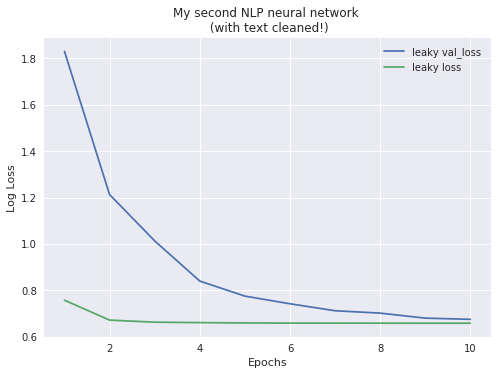

In [64]:
plt.plot(range(1,11), leaky_nlp_hist2.history['val_loss'], label = 'leaky val_loss')
plt.plot(range(1,11), leaky_nlp_hist2.history['loss'], label = 'leaky loss')
plt.title("My second NLP neural network \n (with text cleaned!)")
plt.xlabel("Epochs")
plt.ylabel("Log Loss")
plt.legend()
plt.show()

In [49]:
leaky_nlp_nn.save('QUORA_leaky.h5')

In [50]:
leaky_nlp_hist3 = leaky_nlp_nn.fit([clean_q1_train, clean_q2_train, train_leaks], clean_labels_train, batch_size = 2048, 
                                   nb_epoch = 5, 
                     validation_data=([clean_q1_valid, clean_q2_valid, valid_leaks],clean_labels_valid))

Train on 323402 samples, validate on 80886 samples
Epoch 1/5
323402/323402 [==============================] - 130s - loss: 0.6586 - val_loss: 0.6652
Epoch 2/5
323402/323402 [==============================] - 131s - loss: 0.6586 - val_loss: 0.6572
Epoch 3/5
323402/323402 [==============================] - 131s - loss: 0.6585 - val_loss: 0.6565
Epoch 4/5
323402/323402 [==============================] - 131s - loss: 0.6586 - val_loss: 0.6568
Epoch 5/5
323402/323402 [==============================] - 131s - loss: 0.6585 - val_loss: 0.6587


In [51]:
leaky_nlp_nn.save('QUORA_leaky.h5')

In [52]:
np.save('QUORA_q1_train', clean_q1_train)
np.save('QUORA_q2_train', clean_q2_train)
np.save('QUORA_q2_valid', clean_q2_valid)
np.save('QUORA_q1_valid', clean_q1_valid)
np.save('QUORA_train_leak', train_leaks)
np.save('QUORA_valid_leak', valid_leaks)
np.save('QUORA_train_labels', clean_labels_train)
np.save('QUORA_valid_labels', clean_labels_valid)

In [60]:
leaky_nlp_nn.compile(Adam(0.0005), loss = 'binary_crossentropy')

In [61]:
leaky_nlp_hist4 = leaky_nlp_nn.fit([clean_q1_train, clean_q2_train, train_leaks], clean_labels_train, batch_size = 2048, 
                                   nb_epoch = 5, 
                     validation_data=([clean_q1_valid, clean_q2_valid, valid_leaks],clean_labels_valid))

Train on 323402 samples, validate on 80886 samples
Epoch 1/5
323402/323402 [==============================] - 131s - loss: 0.6581 - val_loss: 0.6588
Epoch 2/5
323402/323402 [==============================] - 131s - loss: 0.6581 - val_loss: 0.6873
Epoch 3/5
323402/323402 [==============================] - 131s - loss: 0.6581 - val_loss: 0.6809
Epoch 4/5
323402/323402 [==============================] - 131s - loss: 0.6581 - val_loss: 0.6814
Epoch 5/5
323402/323402 [==============================] - 131s - loss: 0.6581 - val_loss: 0.6816


In [62]:
leaky_nlp_nn.save('QUORA_leaky.h5')